In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
import os
os.chdir('cvProject')

FileNotFoundError: ignored

In [ ]:
# The following is needed to allow the use of SIFT 
!pip install opencv-python==4.5.3.*

     |████████████████████████████████| 49.9 MB 94 kB/s 
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.1.2.30
    Uninstalling opencv-python-4.1.2.30:
      Successfully uninstalled opencv-python-4.1.2.30
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [ ]:
# Import library modules
import sys
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image  
# The following is a substitute for cv2.imshow, which Colab does not allow
from google.colab.patches import cv2_imshow

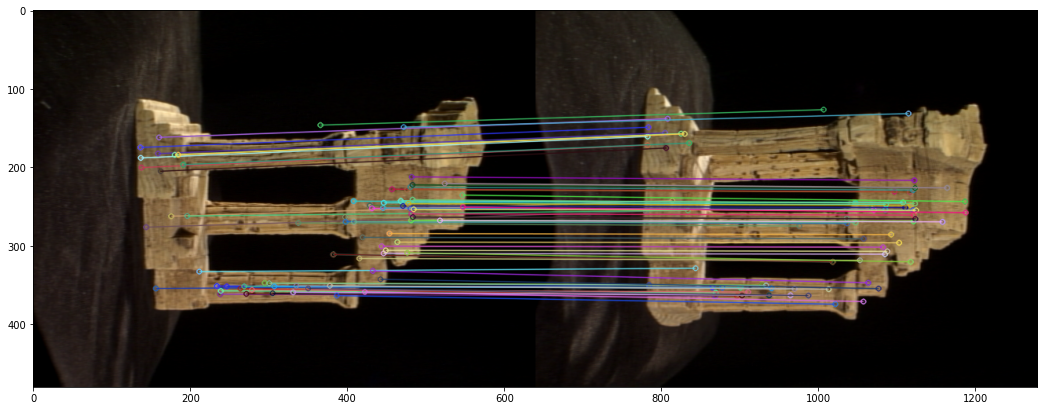

In [ ]:
from skimage.measure import ransac
from skimage.transform import ProjectiveTransform, AffineTransform

def siftMatching(img1, img2):
    # Input : image1 and image2 in opencv format
    # Output : corresponding keypoints for source and target images
    # Output Format : Numpy matrix of shape: [No. of Correspondences X 2] 

    sift = cv2.SIFT_create()
    #kp = sift.detect(img1, None)
    #kp = cv2.SIFT(edgeThreshold=10)
    kp1, des1 = sift.detectAndCompute(img1, None)
    kp2, des2 = sift.detectAndCompute(img2, None)

    FLANN_INDEX_KDTREE = 0
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks = 50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(des1,des2,k=2)

    # Lowe's Ratio test
    good = []
    for m, n in matches:
        if m.distance < 0.7*n.distance:
            good.append(m)

    src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1, 2)
    dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1, 2)

    # Ransac
    model, inliers = ransac(
            (src_pts, dst_pts),
            AffineTransform, min_samples=4,
            residual_threshold=8, max_trials=10000
        )

    n_inliers = np.sum(inliers)

    inlier_keypoints_left = [cv2.KeyPoint(point[0], point[1], 1) for point in src_pts[inliers]]
    inlier_keypoints_right = [cv2.KeyPoint(point[0], point[1], 1) for point in dst_pts[inliers]]
    placeholder_matches = [cv2.DMatch(idx, idx, 1) for idx in range(n_inliers)]
    image3 = cv2.drawMatches(img1, inlier_keypoints_left, img2, inlier_keypoints_right, placeholder_matches, None)

    fig = plt.figure()
    fig.set_size_inches(18,10)
    plt.imshow(cv2.cvtColor(image3, cv2.COLOR_BGR2RGB))    

    src_pts = np.float32([ inlier_keypoints_left[m.queryIdx].pt for m in placeholder_matches ]).reshape(-1, 2)
    dst_pts = np.float32([ inlier_keypoints_right[m.trainIdx].pt for m in placeholder_matches ]).reshape(-1, 2)

    return src_pts, dst_pts


def test_matches():
  img1 = cv2.imread('templeSparseRing/templeSR0001.png')
  img2 = cv2.imread('templeSparseRing/templeSR0002.png')
  
  x1, x2 = siftMatching(img1, img2)
  return x1, x2

x1, x2 = test_matches()

In [ ]:
def triangulate_nviews(P, ip):
    """
    Triangulate a point visible in n camera views.
    P is a list of camera projection matrices.
    ip is a list of homogenised image points. eg [ [x, y, 1], [x, y, 1] ], OR,
    ip is a 2d array - shape nx3 - [ [x, y, 1], [x, y, 1] ]
    len of ip must be the same as len of P
    """
    if not len(ip) == len(P):
        raise ValueError('Number of points and number of cameras not equal.')
    n = len(P)
    M = np.zeros([3*n, 4+n])
    for i, (x, p) in enumerate(zip(ip, P)):
        M[3*i:3*i+3, :4] = p
        M[3*i:3*i+3, 4+i] = -x
    V = np.linalg.svd(M)[-1]
    X = V[-1, :4]
    return X / X[3]


def triangulate_points(P1, P2, x1, x2):
    """
    Two-view triangulation of points in
    x1,x2 (nx3 homog. coordinates).
    Similar to openCV triangulatePoints.
    """
    if not len(x2) == len(x1):
        raise ValueError("Number of points don't match.")
    X = [triangulate_nviews([P1, P2], [x[0], x[1]]) for x in zip(x1, x2)]
    return np.array(X)

In [ ]:
f = open('templeSparseRing/templeSR_par.txt')
for line in f:
  elems = line.split(' ')
  img_name = elem[0]

16

templeSR0001.png 1520.400000 0.000000 302.320000 0.000000 1525.900000 246.870000 0.000000 0.000000 1.000000 0.02187598221295043000 0.98329680886213122000 -0.18068986436368856000 0.99856708067455469000 -0.01266114646423925600 0.05199500709979997700 0.04883878372068499500 -0.18156839221560722000 -0.98216479887691122000 -0.0726637729648 0.0223360353405 0.614604845959

templeSR0002.png 1520.400000 0.000000 302.320000 0.000000 1525.900000 246.870000 0.000000 0.000000 1.000000 -0.03472199972816788400 0.98429285136236500000 -0.17309524976677537000 0.93942192751145170000 -0.02695166652093134900 -0.34170169707277304000 -0.34099974317519038000 -0.17447403941185566000 -0.92373047190496216000 -0.0746307029819 0.0338148092011 0.600850565131

templeSR0003.png 1520.400000 0.000000 302.320000 0.000000 1525.900000 246.870000 0.000000 0.000000 1.000000 -0.12459423323539082000 0.98895928871004091000 -0.08022345242268591500 0.28153512590579682000 -0.04229297064421112100 -0.95861842122676455000 -0.9514

In [ ]:
K1 = np.array([[1520.400000, 0.000000, 302.320000], [0.000000, 1525.900000, 246.870000], [0.000000, 0.000000, 1.000000]])
Rt1 = np.array([[0.02187598221295043000, 0.98329680886213122000, -0.18068986436368856000, -0.0726637729648], [0.99856708067455469000, -0.01266114646423925600, 0.05199500709979997700, 0.0223360353405], [0.04883878372068499500, -0.18156839221560722000, -0.98216479887691122000, 0.614604845959]])
P1 = np.dot(K1, Rt1)

K2 = np.array([[1520.400000, 0.000000, 302.320000], [0.000000, 1525.900000, 246.870000], [0.000000, 0.000000, 1.000000]])
Rt2 = np.array([[-0.03472199972816788400, 0.98429285136236500000, -0.17309524976677537000, -0.0746307029819], [0.93942192751145170000, -0.02695166652093134900, -0.34170169707277304000, 0.0338148092011], [-0.34099974317519038000, -0.17447403941185566000, -0.92373047190496216000, 0.600850565131]])
P2 = np.dot(K2, Rt2)

In [ ]:
print('Triangulate 3d points - units in meters')
# triangulatePoints requires 2xn arrays, so transpose the points
p12 = cv2.triangulatePoints(P1, P2, x1.T, x2.T)
# however, homgeneous point is returned
p12 /= p12[3]

Triangulate 3d points - units in meters


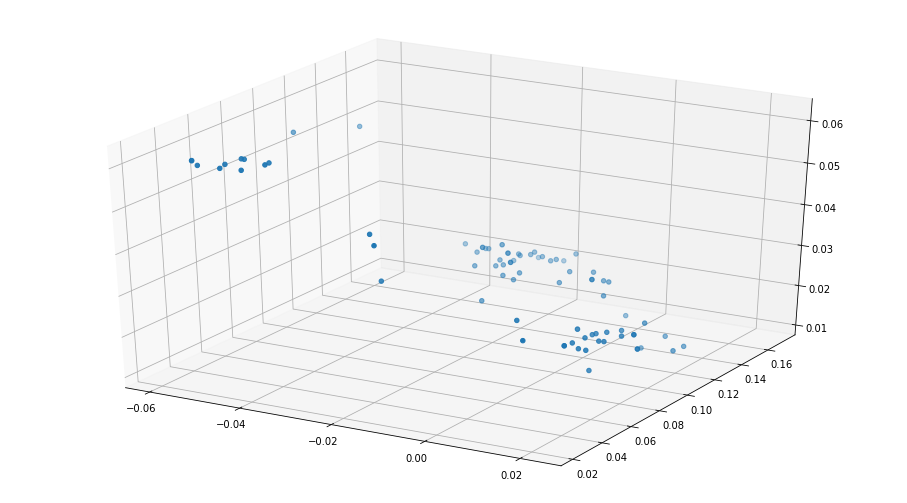

In [ ]:
fig = plt.figure()
fig.set_size_inches(16,9)
ax = plt.axes(projection='3d')
ax.scatter(p12.T[:,0], p12.T[:,1], p12.T[:,2])